In [1]:
import os

In [2]:
os.environ["DGLBACKEND"] = "pytorch"

In [3]:
import torch 
import pandas as pd
import dgl
from dgl.data import DGLDataset
import dgl.function as fn
import numpy as np

In [4]:
ds = dgl.data.CSVDataset('./DGL_playground/toy_dataset/')

Done loading data from cached files.


In [5]:
g = ds[0]

In [6]:
print(g)


Graph(num_nodes=10, num_edges=20,
      ndata_schemes={' na2': Scheme(shape=(), dtype=torch.int64), ' na1': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'ea2': Scheme(shape=(), dtype=torch.int64), 'ea1': Scheme(shape=(), dtype=torch.int64), 'w': Scheme(shape=(), dtype=torch.int64)})


### Define Weights

The weights need to be constant along any bi-directed edge. DGL does not provide a function to ensure this happens. Currently a for loop is being used to ensure identical weights along edges - a better solution needs to be found to ensure scalability of the model.

In [42]:
g.edata['w'] = torch.rand(g.num_edges(),1)
# g.edata['w']

In [44]:
g.edges("all")

(tensor([0, 0, 0, 1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8]),
 tensor([1, 2, 3, 0, 2, 0, 1, 0, 4, 5, 3, 5, 3, 4, 7, 8, 6, 8, 6, 7]),
 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19]))

In [61]:
# Obtain source, destination and edge ids for all edges
[src, dst, eid] = g.edges(form = 'all')

# Loop through edges to identify bi-directional edges to then assign same weights
# This loop can be optimized but ideally needs to be replaced with an parallelisable function
for i in eid:
    for j in eid:
        if (src[i] == dst[j] and dst[i] == src[j]): #For edges with same nodes
            g.edata['w'][j] = g.edata['w'][i]
            break
g.edata['w']

tensor([[0.3884],
        [0.2080],
        [0.3543],
        [0.3884],
        [0.4906],
        [0.2080],
        [0.4906],
        [0.3543],
        [0.0083],
        [0.5370],
        [0.0083],
        [0.1887],
        [0.5370],
        [0.1887],
        [0.6262],
        [0.7805],
        [0.6262],
        [0.4563],
        [0.7805],
        [0.4563]])

In [62]:
#Create wealth per node/agent in the network as a node feature/attribute
g.ndata['k'] = torch.rand(g.num_nodes(),1)*1000

In [63]:
#Create savings propensity as a node features per agent
g.ndata['lambda'] = torch.rand(g.num_nodes(),1)

In [65]:
#Initialize some base node attributes (0s, and 1s)
g.ndata['zeros'] = torch.zeros(g.num_nodes(),1)
g.ndata['ones'] = torch.ones(g.num_nodes(),1)

In [91]:
#Calculate number of neighbours (tot_nbr) each node has using built-in functions
g.update_all(fn.u_add_v('zeros','ones','tot_nbr'), fn.sum('tot_nbr', 'tot_nbr'))
g.ndata['tot_nbr']

tensor([[3.],
        [2.],
        [2.],
        [3.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [0.]])

In [69]:
#Calculate total weight of all incoming (or outgoing, equivalent bidirectional graph) edges to each node
g.ndata['tot_wgt'] = torch.zeros(g.num_nodes(),1)
g.update_all(fn.u_add_e('tot_wgt','w','tot_wgt'), fn.sum('tot_wgt', 'tot_wgt'))
g.ndata['tot_wgt']

tensor([[0.9508],
        [0.8791],
        [0.6987],
        [0.8996],
        [0.1970],
        [0.7257],
        [1.4066],
        [1.0825],
        [1.2368],
        [0.0000]])

In [71]:
# e_div_u divides the edge feature by the feature of the source node for outgoing edges
# However, u_add_e addes the features of edges with source node for incoming edges
# Not sure if this discrepancy is intentional
g.apply_edges(fn.e_div_u('w','tot_wgt','per_wgt'))
g.edata['per_wgt']

tensor([[0.4085],
        [0.2188],
        [0.3727],
        [0.4419],
        [0.5581],
        [0.2978],
        [0.7022],
        [0.3939],
        [0.0092],
        [0.5969],
        [0.0420],
        [0.9580],
        [0.7399],
        [0.2601],
        [0.4451],
        [0.5549],
        [0.5784],
        [0.4216],
        [0.6310],
        [0.3690]])

In [77]:
# Calculate disposable wealth depending on savings propensity (lambda) and wealth (k)
g.ndata['disp_wealth'] = g.ndata['lambda']*g.ndata['k']
g.ndata['disp_wealth']

tensor([[168.6985],
        [228.1343],
        [ 23.8596],
        [183.6691],
        [163.6480],
        [ 95.3177],
        [334.3804],
        [392.6791],
        [176.9619],
        [ 41.7966]])

In [78]:
#Calculate income to be transferred along an edge
g.apply_edges(fn.e_mul_u('per_wgt','disp_wealth','trfr_wealth'))
g.edata['trfr_wealth']

tensor([[ 68.9184],
        [ 36.9117],
        [ 62.8684],
        [100.8042],
        [127.3301],
        [  7.1044],
        [ 16.7553],
        [ 72.3448],
        [  1.6881],
        [109.6362],
        [  6.8678],
        [156.7802],
        [ 70.5273],
        [ 24.7904],
        [148.8491],
        [185.5313],
        [227.1392],
        [165.5399],
        [111.6684],
        [ 65.2935]])

In [81]:
# Message passing along edges to sum total income obtained from neighbours for each node/agent
g.update_all(fn.v_add_e('zeros','trfr_wealth','delta_inc'), fn.sum('delta_inc', 'delta_inc'))
g.ndata['delta_inc']

tensor([[180.2534],
        [ 85.6737],
        [164.2418],
        [140.2636],
        [ 26.4785],
        [266.4163],
        [338.8076],
        [214.1426],
        [351.0713],
        [  0.0000]])

In [83]:
# Update income for next time-step
# This and the previous step can be simplified by directly updating k in the final model
g.ndata['k_new'] = g.ndata['k'] + g.ndata['delta_inc']
g.ndata['k_new']

tensor([[ 660.7891],
        [ 329.8923],
        [ 407.0394],
        [ 414.1487],
        [ 812.1682],
        [1132.3524],
        [ 682.6328],
        [ 868.2972],
        [ 632.1979],
        [ 122.4313]])

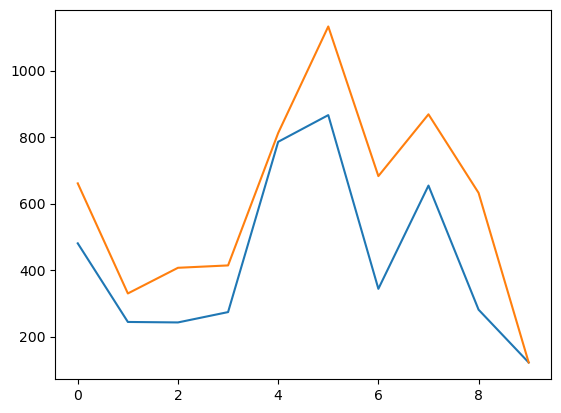

In [87]:
#Plotting current wealth and updated wealth for each agent for one time-step
import matplotlib.pyplot as plt

plt.plot(g.ndata['k'])
plt.plot(g.ndata['k_new'])